In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow, LinearChol
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
    lowerd = DFlow([NVPFlow(dim=k*(k-1)//2 + k, name='lowerd_flow_' + str(i)) for i in range(4)])
    ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
                   lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([LinearChol(dim=dim[0]*dim[1], name='lc', aux_vars=aux_vars)], 
                          init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    if i >= 1:
        aux = tf.concat([outputs[-1], outputs[-2]], 1)
#     elif i>= 2:
#         aux = tf.concat([outputs[-1], outputs[-2], outputs[-3]], 1)
    else:
        aux = outputs[-1]
    new = create_step_flow('step_flow' + str(i+1), aux, init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
aux

<tf.Tensor 'concat_17:0' shape=(1, 24) dtype=float64>

In [10]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [11]:
outputs

<tf.Tensor 'strided_slice_2:0' shape=(1, 20, 12) dtype=float64>

In [12]:
prior = PWalk.logdens(outputs)

In [13]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [14]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [15]:
logl = create_loglik2()

In [16]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [17]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [18]:
df = dim[0]*dim[1]
pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [19]:
loss = -logl - prior + ent - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [20]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [21]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
prior.eval(), ent.eval(), logl.eval()

(-111966.97458302557, 713.236171144621, -2111.9674142043327)

In [25]:
loss.eval()

array([536.74997658])

In [26]:
np.set_printoptions(precision=4)

In [27]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 3.1587e+03,  3.5889e+01, -1.0495e+01],
       [ 3.5889e+01,  9.8899e+02, -2.4275e+01],
       [-1.0495e+01, -2.4275e+01,  1.1165e+04]])

In [28]:
# all_sum = tf.summary.merge_all()
# writer = tf.summary.FileWriter('/tmp/tfdbg')

In [ ]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
#     writer.add_summary(all_sum.eval())

[157.2477]
[[ 2.6605e+03 -8.3815e+00  5.4570e+01]
 [-8.3815e+00  3.5234e+02  1.5285e+01]
 [ 5.4570e+01  1.5285e+01  2.8378e+04]]


[35.3533]
[[20309.9233   101.5377  -181.3936]
 [  101.5377  6491.43     -22.2804]
 [ -181.3936   -22.2804  6616.3419]]


[25.0434]
[[ 2.7264e+03 -8.4637e+01 -2.8264e+01]
 [-8.4637e+01  8.6543e+04  4.7309e+01]
 [-2.8264e+01  4.7309e+01  4.9511e+03]]


[22.8544]
[[29500.8848 -2505.827  -1513.6927]
 [-2505.827  18880.8561  1494.1888]
 [-1513.6927  1494.1888 52520.1035]]


[66.145]
[[  2652.1385  -1152.7519   -331.0626]
 [ -1152.7519   3224.5585   1411.7699]
 [  -331.0626   1411.7699 108726.8704]]


[49.1913]
[[ 7414.8667 -1018.6181 -1418.4391]
 [-1018.6181 11158.5353   310.9649]
 [-1418.4391   310.9649 13376.6487]]


[53.9251]
[[5188.9498 1450.7284  453.7921]
 [1450.7284 3899.8191  634.8753]
 [ 453.7921  634.8753 2599.3424]]


[50.6181]
[[ 2604.818   -143.6258  -157.6601]
 [ -143.6258 10469.0445  1470.2257]
 [ -157.6601  1470.2257 13253.4057]]


[16.559]
[[  3

[3.8993]
[[3146.4788 -174.6175   37.122 ]
 [-174.6175 5178.7842 -312.3427]
 [  37.122  -312.3427 6518.4828]]


[3.5632]
[[5840.9989  518.6487 -342.5889]
 [ 518.6487 4865.3183 1350.1126]
 [-342.5889 1350.1126 5275.0065]]


[4.0653]
[[ 4021.6167  -652.9574 -2473.7375]
 [ -652.9574  4538.7217   935.2597]
 [-2473.7375   935.2597  5984.5203]]


[3.7487]
[[4986.087  -600.667  2912.5192]
 [-600.667  2559.6651  672.2787]
 [2912.5192  672.2787 7013.9174]]


[3.8563]
[[ 4190.0595   -62.0782 -1356.0677]
 [  -62.0782  6124.1422 -1033.8338]
 [-1356.0677 -1033.8338  6266.8726]]


[3.6696]
[[2570.4327 -358.7991 -464.8803]
 [-358.7991 2541.8688  874.1974]
 [-464.8803  874.1974 2254.5894]]


[3.8898]
[[2699.3369  410.8776  189.5103]
 [ 410.8776 4123.242  1210.4481]
 [ 189.5103 1210.4481 7863.8313]]


[3.9207]
[[2690.7422   27.8792 -406.1367]
 [  27.8792 5076.304  -468.5794]
 [-406.1367 -468.5794 7305.1107]]


[4.0145]
[[3315.6653  -54.6103 -322.7456]
 [ -54.6103 6914.6335 -348.2755]
 [-322.7456 -348.27

[3.4791]
[[ 3488.3892   302.4531 -1340.2934]
 [  302.4531  2925.2707  -115.2345]
 [-1340.2934  -115.2345  9118.4725]]


[3.5037]
[[ 4394.8969 -1071.4868   815.6803]
 [-1071.4868  3227.6343  -863.5687]
 [  815.6803  -863.5687  5579.7651]]


[3.4588]
[[4073.2345  676.7862 -433.0435]
 [ 676.7862 3514.5185 1453.1825]
 [-433.0435 1453.1825 4821.1053]]


[3.4045]
[[1255.5838  300.6021 -909.7092]
 [ 300.6021 3128.6168 -299.2793]
 [-909.7092 -299.2793 4048.597 ]]


[3.4148]
[[ 1903.672  -1845.0406   465.7469]
 [-1845.0406  5188.6828 -1663.4381]
 [  465.7469 -1663.4381  5336.4834]]


[3.4381]
[[2599.5583  220.853  -102.742 ]
 [ 220.853  6110.1532  514.078 ]
 [-102.742   514.078  4381.8037]]


[3.3877]
[[ 5306.106   -582.947   1443.9985]
 [ -582.947   6050.7617 -1664.8491]
 [ 1443.9985 -1664.8491  4900.5456]]


[3.3614]
[[2640.468  1230.407  -162.319 ]
 [1230.407  9044.2352 1004.0544]
 [-162.319  1004.0544 3458.1559]]


[3.3759]
[[ 2033.2574   585.2276  -634.0731]
 [  585.2276  3869.7432 -2008.5

[3.2467]
[[1652.2009  670.5085 1013.2996]
 [ 670.5085 5954.3397 -300.2765]
 [1013.2996 -300.2765 7466.9861]]


[3.3626]
[[ 1896.0868    38.1042 -1050.3114]
 [   38.1042  2808.057   1406.1587]
 [-1050.3114  1406.1587  6484.0339]]


[3.2429]
[[ 2.8637e+03 -1.0129e+03 -9.4407e-01]
 [-1.0129e+03  4.6982e+03  1.6870e+03]
 [-9.4407e-01  1.6870e+03  9.0307e+03]]


[3.2117]
[[2330.8937   21.06    336.4059]
 [  21.06   2502.4026 -584.8752]
 [ 336.4059 -584.8752 3881.1476]]


[3.1955]
[[3550.5616 -285.9561  956.8688]
 [-285.9561 3076.1781 1545.317 ]
 [ 956.8688 1545.317  5625.7828]]


[3.2284]
[[1183.6614  119.6702  -79.1894]
 [ 119.6702 4476.172   196.5261]
 [ -79.1894  196.5261 5704.7197]]


[3.3388]
[[ 1808.4103   242.7766   -82.1181]
 [  242.7766  2448.4235 -1144.2074]
 [  -82.1181 -1144.2074  5426.3496]]


[3.2609]
[[2044.5356 -706.8313  -76.8712]
 [-706.8313 5613.1463  889.9231]
 [ -76.8712  889.9231 7556.9162]]


[3.3099]
[[ 902.8696 -349.9311 -587.9129]
 [-349.9311 5121.8689 1591.4894]
 

[3.162]
[[ 1075.9891   267.1537 -1447.4117]
 [  267.1537  3841.1312  1538.4349]
 [-1447.4117  1538.4349  6266.9286]]


[3.074]
[[1543.1624  536.6625 -736.8915]
 [ 536.6625 2152.251  -915.9736]
 [-736.8915 -915.9736 4102.4251]]


[3.1515]
[[1054.6021  118.8165  568.1035]
 [ 118.8165 6044.9597  548.103 ]
 [ 568.1035  548.103  5347.0528]]


[3.2756]
[[1637.6482 -111.456  -134.4508]
 [-111.456  6526.7317 1773.7906]
 [-134.4508 1773.7906 5877.9873]]


[3.1596]
[[2561.2709 -634.5063 1132.032 ]
 [-634.5063 3475.3433 1267.7414]
 [1132.032  1267.7414 9800.7026]]


[3.2272]
[[2070.4629   65.2784 -229.5732]
 [  65.2784 2614.0843 -910.6987]
 [-229.5732 -910.6987 4385.7064]]


[3.1148]
[[ 2213.5399   -20.9173  -783.5734]
 [  -20.9173  3670.2109   -91.2602]
 [ -783.5734   -91.2602 13278.3588]]


[3.1373]
[[  797.5922  -178.4872   396.6879]
 [ -178.4872  4767.0731 -1078.4658]
 [  396.6879 -1078.4658  4411.7565]]


[3.1281]
[[2101.4123 -686.5012 -106.0722]
 [-686.5012 2313.101  -183.7337]
 [-106.0722 

[3.0239]
[[ 783.1167 -414.0565  209.5511]
 [-414.0565 3622.4928 -520.3996]
 [ 209.5511 -520.3996 6553.0959]]


[3.043]
[[1264.9211  173.6401  824.6259]
 [ 173.6401 2468.0603  657.9003]
 [ 824.6259  657.9003 6721.5726]]


[3.0604]
[[ 789.2694 -239.9983 -582.1673]
 [-239.9983 3409.3911  112.1246]
 [-582.1673  112.1246 5882.8111]]


[3.0625]
[[  942.6288  -152.8554   -52.9672]
 [ -152.8554  3357.0808 -1034.5054]
 [  -52.9672 -1034.5054  2959.0582]]


[3.1228]
[[1212.9073 -688.5529 -206.8982]
 [-688.5529 1908.4016  647.6979]
 [-206.8982  647.6979 7601.0263]]


[3.1172]
[[ 2450.9711   963.6333 -1009.0267]
 [  963.6333  4121.3757   377.7341]
 [-1009.0267   377.7341  7445.3495]]


[3.0412]
[[1014.4282  263.4006  207.1859]
 [ 263.4006 3152.4941  240.878 ]
 [ 207.1859  240.878  7108.5929]]


[3.122]
[[1216.331  -558.368   397.5377]
 [-558.368  3057.2948   38.8704]
 [ 397.5377   38.8704 6458.0501]]


[3.0507]
[[1118.8707 -490.8584  333.1072]
 [-490.8584 3785.5277 -502.1638]
 [ 333.1072 -502.1638

[3.0017]
[[ 849.6063  437.2687  199.4064]
 [ 437.2687 1955.6196  765.5821]
 [ 199.4064  765.5821 8140.023 ]]


[3.0402]
[[ 1516.011     74.3633 -1478.2218]
 [   74.3633  4651.9916   658.7531]
 [-1478.2218   658.7531  6227.3756]]


[2.9577]
[[1014.2848 -441.3718 -516.5489]
 [-441.3718 2521.3513 1107.4789]
 [-516.5489 1107.4789 9250.0193]]


[2.9681]
[[ 922.1313 -204.6294 -521.0578]
 [-204.6294 2420.467  -623.0706]
 [-521.0578 -623.0706 3187.5131]]


[3.0381]
[[1013.9512 -151.8042 1191.5142]
 [-151.8042 1316.2992 -633.3163]
 [1191.5142 -633.3163 6006.101 ]]


[2.923]
[[ 989.4648  645.6903   80.6864]
 [ 645.6903 4163.9873 1069.9918]
 [  80.6864 1069.9918 5374.5919]]


[2.9824]
[[1106.4143  -53.0092   29.0231]
 [ -53.0092 2395.4826  402.1443]
 [  29.0231  402.1443 5210.6932]]


[2.9577]
[[1109.2771 -707.6894   23.8319]
 [-707.6894 2602.2607 2031.1409]
 [  23.8319 2031.1409 5636.2508]]


[2.9036]
[[1159.2915  691.9025 -930.6756]
 [ 691.9025 4162.5695  775.1201]
 [-930.6756  775.1201 7236.73

[2.9479]
[[ 558.9142   85.215  -590.5142]
 [  85.215  1405.5012 -492.3249]
 [-590.5142 -492.3249 4292.8205]]


[2.9145]
[[ 697.625  -494.8959 -199.1862]
 [-494.8959 3235.4972  505.1034]
 [-199.1862  505.1034 4076.9086]]


[3.2559]
[[ 954.927   -19.6082 -340.8222]
 [ -19.6082 2551.6929  746.6758]
 [-340.8222  746.6758 9323.7371]]


[2.9242]
[[  757.3078   560.1851  -320.1249]
 [  560.1851  2188.487  -1667.6768]
 [ -320.1249 -1667.6768  5814.6289]]


[2.9743]
[[ 639.0732   21.2826 -195.6308]
 [  21.2826 2864.5006  527.2019]
 [-195.6308  527.2019 5860.3463]]


[2.8934]
[[1071.2593 -303.4386 -273.4115]
 [-303.4386 2760.593  -740.0842]
 [-273.4115 -740.0842 8410.2233]]


[2.8779]
[[1648.7124 -124.5888  862.3552]
 [-124.5888 2279.1024 -495.6847]
 [ 862.3552 -495.6847 9990.7863]]


[2.9571]
[[ 1033.3991   662.7974   675.9234]
 [  662.7974  4172.5914 -2255.1881]
 [  675.9234 -2255.1881 13807.6292]]


[2.9915]
[[ 964.0807   89.1031 1187.2801]
 [  89.1031 2617.2402 1546.0135]
 [1187.2801 1546.01

[2.9287]
[[1227.2895  654.2082  595.7156]
 [ 654.2082 3933.1862 -593.1414]
 [ 595.7156 -593.1414 4803.768 ]]


[2.8963]
[[ 1237.7664  -426.4742    75.6958]
 [ -426.4742  3537.8982  2224.1964]
 [   75.6958  2224.1964 10232.4571]]


[2.926]
[[  957.494   -221.1908   462.7191]
 [ -221.1908  2641.5179  1756.582 ]
 [  462.7191  1756.582  14496.1158]]


[2.8624]
[[ 544.0974  -54.3505 -447.6816]
 [ -54.3505 2628.4602  314.5918]
 [-447.6816  314.5918 7841.8575]]


[2.8876]
[[  894.1956    74.5935  1012.4598]
 [   74.5935  2659.5822   838.5265]
 [ 1012.4598   838.5265 17031.3119]]


[2.7772]
[[  633.6506  -330.7591  -178.4999]
 [ -330.7591  2087.7202  -275.3991]
 [ -178.4999  -275.3991 12260.243 ]]


[2.916]
[[  811.4866  -258.5832  -732.0574]
 [ -258.5832  2206.5733  2493.3156]
 [ -732.0574  2493.3156 12097.9494]]


[2.9522]
[[ 955.5106 -341.1543  758.0443]
 [-341.1543 2825.9652 -818.108 ]
 [ 758.0443 -818.108  9710.391 ]]


[2.9318]
[[  838.3138   -58.2013  1169.3632]
 [  -58.2013  2804.8745 

[3.0474]
[[1160.8372  395.2264 1018.6717]
 [ 395.2264 4014.0883 1708.2429]
 [1018.6717 1708.2429 9930.0367]]


[2.8276]
[[ 1116.3774  -349.6967   755.4266]
 [ -349.6967  2987.1157 -1573.3765]
 [  755.4266 -1573.3765  6440.5448]]


[2.8304]
[[ 1.5554e+03 -1.4498e+00  8.7987e+02]
 [-1.4498e+00  4.3089e+03  1.9484e+03]
 [ 8.7987e+02  1.9484e+03  6.4548e+03]]


[2.8154]
[[  467.2691   -43.4779   193.0762]
 [  -43.4779  2168.2902 -1104.3903]
 [  193.0762 -1104.3903  5849.4597]]


[2.8484]
[[ 813.3055  -32.0668  663.9342]
 [ -32.0668 3761.6403 1709.1141]
 [ 663.9342 1709.1141 9697.1544]]


[2.7744]
[[1029.6227 -251.8342  -80.7739]
 [-251.8342 2347.0751  -84.9098]
 [ -80.7739  -84.9098 6532.5305]]


[2.8088]
[[ 924.8668 -133.1521 -869.6951]
 [-133.1521 3118.3744 2379.5135]
 [-869.6951 2379.5135 7568.5021]]


[2.8031]
[[  618.6357  -636.111    -49.0479]
 [ -636.111   3590.0454  1531.2437]
 [  -49.0479  1531.2437 12191.8253]]


[2.9321]
[[ 3.2803e+02  2.5618e+02 -2.2838e+02]
 [ 2.5618e+02  3.47

[2.8182]
[[  511.8935  -193.369   1011.636 ]
 [ -193.369   3448.9499   331.035 ]
 [ 1011.636    331.035  18121.8462]]


[2.8916]
[[ 1619.6251  -562.2497   562.3044]
 [ -562.2497  3311.2575   867.3955]
 [  562.3044   867.3955 11497.3575]]


[2.7953]
[[  924.691    536.8151   280.2819]
 [  536.8151  4981.7808  3463.6284]
 [  280.2819  3463.6284 10232.2092]]


[2.796]
[[ 703.2686  770.435   142.4797]
 [ 770.435  5014.6289 -469.0262]
 [ 142.4797 -469.0262 5543.3996]]


[2.8777]
[[ 790.0942 -363.4702 -400.8394]
 [-363.4702 3198.349  1201.0732]
 [-400.8394 1201.0732 7976.1923]]


[2.7249]
[[ 900.7212 -600.6972 -219.4709]
 [-600.6972 2189.5187  306.0023]
 [-219.4709  306.0023 9716.5682]]


[2.8659]
[[  360.5511   305.7483  -111.9389]
 [  305.7483  3362.189   -181.8234]
 [ -111.9389  -181.8234 12434.1875]]


[2.8222]
[[1453.9502  645.8339 -679.4817]
 [ 645.8339 6586.214    89.5377]
 [-679.4817   89.5377 5142.3569]]


[2.8051]
[[  865.6016  -200.6787   542.2513]
 [ -200.6787  2823.5738   -79.99

[2.8487]
[[ 1082.7393  -337.7487   546.3894]
 [ -337.7487  5876.3993 -2821.0179]
 [  546.3894 -2821.0179 10366.0969]]


[2.7372]
[[  728.0143  -308.9281    23.1258]
 [ -308.9281  5063.0665  1700.8699]
 [   23.1258  1700.8699 12976.1418]]


[2.8353]
[[ 957.1874 -246.7518  107.6072]
 [-246.7518 5560.353  -641.842 ]
 [ 107.6072 -641.842  8983.43  ]]


[2.7674]
[[  678.6153   354.3188  -687.2209]
 [  354.3188  3602.1352  -106.418 ]
 [ -687.2209  -106.418  12380.5686]]


[3.0409]
[[1757.9683 -556.842   208.0471]
 [-556.842  3660.1317  578.0188]
 [ 208.0471  578.0188 7036.9406]]


[2.7668]
[[  625.957    307.2436    66.8023]
 [  307.2436  3654.5862  -117.8845]
 [   66.8023  -117.8845 10530.7204]]


[2.8019]
[[  947.5151   411.4049   878.5994]
 [  411.4049  2824.9357  -504.9481]
 [  878.5994  -504.9481 17495.5653]]


[2.7971]
[[ 1398.1095  -265.1864  1734.762 ]
 [ -265.1864  2537.7846   754.2557]
 [ 1734.762    754.2557 10542.4924]]


[2.7062]
[[  840.7607  -383.3251 -1941.1848]
 [ -383.3251 

[2.8238]
[[  609.6902  -225.0571   618.5107]
 [ -225.0571  4412.2941 -2625.2357]
 [  618.5107 -2625.2357 15306.7123]]


[2.7185]
[[  844.0868   156.2343   391.2129]
 [  156.2343  3115.7998 -1070.4583]
 [  391.2129 -1070.4583  9282.8781]]


[2.7936]
[[  625.2125   201.6616 -1456.3414]
 [  201.6616  3039.3363  1060.4329]
 [-1456.3414  1060.4329 16564.4652]]


[2.8414]
[[  465.6458   -93.5332   781.9506]
 [  -93.5332  3951.8741   107.9122]
 [  781.9506   107.9122 18278.4357]]


[2.7672]
[[ 1120.0402   323.8129   477.3064]
 [  323.8129  4053.7559  5596.1163]
 [  477.3064  5596.1163 21394.7828]]


[2.7753]
[[  697.5083  -387.7901 -1140.3529]
 [ -387.7901  3631.6116  3549.8108]
 [-1140.3529  3549.8108 16136.8767]]


[2.8509]
[[  812.3389   199.5679  1571.6539]
 [  199.5679  1667.2353   604.1211]
 [ 1571.6539   604.1211 14144.3775]]


[2.7525]
[[  573.7442    20.681   -251.6328]
 [   20.681   5055.8479  -401.4556]
 [ -251.6328  -401.4556 10969.5896]]


[2.798]
[[  655.085   -713.7201   -77.24

[2.6585]
[[ 1288.1861   865.0952  1444.1628]
 [  865.0952  2320.4861  1985.3185]
 [ 1444.1628  1985.3185 18984.7544]]


[2.7754]
[[ 1042.5105   355.095   -327.0993]
 [  355.095   3807.8965  2691.3325]
 [ -327.0993  2691.3325 20037.2106]]


[2.6698]
[[ 1119.9573   528.6029    98.689 ]
 [  528.6029  2982.9871   396.748 ]
 [   98.689    396.748  15164.4976]]


[2.6957]
[[ 1128.379    339.5983  -507.9799]
 [  339.5983  2705.1792 -2396.4713]
 [ -507.9799 -2396.4713 17573.5683]]


[2.709]
[[  794.0834  -410.8542   469.7859]
 [ -410.8542  2926.0102   515.2425]
 [  469.7859   515.2425 12703.971 ]]


[2.6849]
[[ 1044.2134   220.9549   289.2028]
 [  220.9549  3298.0261 -2471.8553]
 [  289.2028 -2471.8553 15547.6512]]


[3.1118]
[[  923.8687   299.0255   178.7448]
 [  299.0255  5841.9599  -529.2867]
 [  178.7448  -529.2867 14201.5136]]


[2.8069]
[[ 1276.3355  -363.2963  2806.235 ]
 [ -363.2963  4607.5833 -3975.9243]
 [ 2806.235  -3975.9243 15816.9054]]


[2.7448]
[[  796.4319  -131.411   1435.37

[2.7068]
[[  655.4732   -63.9041  -784.8785]
 [  -63.9041  3755.418   -399.217 ]
 [ -784.8785  -399.217  14763.4746]]


[2.7246]
[[  915.8826   154.1751    66.6032]
 [  154.1751  5221.7589  -626.8145]
 [   66.6032  -626.8145 21209.4376]]


[2.7231]
[[  949.8858   718.4654  1896.2588]
 [  718.4654  6085.6904   680.5284]
 [ 1896.2588   680.5284 23307.1566]]


[2.7457]
[[ 1194.456    491.6808 -1495.4415]
 [  491.6808  3365.7912   647.9821]
 [-1495.4415   647.9821 13002.0304]]


[2.8176]
[[  612.9635   -47.5864  -348.7683]
 [  -47.5864  3844.6057 -1245.3455]
 [ -348.7683 -1245.3455  9098.3058]]


[2.7686]
[[  955.6744   291.9626   855.6419]
 [  291.9626  5702.1463 -2868.7271]
 [  855.6419 -2868.7271 13776.8761]]


[2.7046]
[[  655.4785   100.8989   569.0789]
 [  100.8989  3867.113    409.9488]
 [  569.0789   409.9488 22144.6469]]


[2.7313]
[[  624.4136   -96.5506    76.2004]
 [  -96.5506  2540.9431 -1327.2634]
 [   76.2004 -1327.2634 13406.6432]]


[2.7816]
[[  833.3908   462.7231   964.9

[2.7613]
[[  717.681    -69.754  -1330.0687]
 [  -69.754   4104.81    4003.4912]
 [-1330.0687  4003.4912 17497.8691]]


[2.8082]
[[  662.5073   260.54     -78.8072]
 [  260.54    4984.7117  -555.5301]
 [  -78.8072  -555.5301 26462.0078]]


[2.7487]
[[ 1140.6207  -864.4506  1444.2624]
 [ -864.4506  4691.4857   347.332 ]
 [ 1444.2624   347.332  20408.7865]]


[3.0771]
[[ 1.0237e+03  1.0176e+01 -1.3125e+02]
 [ 1.0176e+01  4.2516e+03  1.5943e+03]
 [-1.3125e+02  1.5943e+03  4.3428e+04]]


[2.77]
[[ 1281.1406    24.8714    70.5878]
 [   24.8714  5609.9126  -612.1977]
 [   70.5878  -612.1977 20928.3577]]


[2.7155]
[[  727.666   -125.3226  1573.6093]
 [ -125.3226  4014.2583   211.1652]
 [ 1573.6093   211.1652 19542.1145]]


[2.7231]
[[ 1047.0457   147.0417   463.511 ]
 [  147.0417  6339.4018  3281.0955]
 [  463.511   3281.0955 17305.476 ]]


[2.7392]
[[ 1208.0705   333.6895   687.6895]
 [  333.6895  2428.2201  1589.149 ]
 [  687.6895  1589.149  13719.0337]]


[2.7327]
[[  786.3265  -314.4636 

[2.7174]
[[  736.8718   233.1686   252.0174]
 [  233.1686  3204.4589  2870.763 ]
 [  252.0174  2870.763  17740.0003]]


[2.7128]
[[  814.3871  -342.382     83.5632]
 [ -342.382   4079.6182  1940.5516]
 [   83.5632  1940.5516 26671.8987]]


[2.8867]
[[  870.298     80.311   -677.5474]
 [   80.311   3023.4666  -792.9898]
 [ -677.5474  -792.9898 17404.7375]]


[2.7067]
[[  774.3993  -114.3916  1438.1471]
 [ -114.3916  4184.7222  4646.4411]
 [ 1438.1471  4646.4411 37392.1778]]


[2.7849]
[[  776.8317   790.1042  -890.1201]
 [  790.1042  6904.0678 -1283.2526]
 [ -890.1201 -1283.2526 20105.424 ]]


[2.6484]
[[ 1462.8024    54.3641   946.4177]
 [   54.3641  6285.2934  1900.6835]
 [  946.4177  1900.6835 18806.7747]]


[2.7465]
[[  758.1067   282.4012  -883.5906]
 [  282.4012  5429.754   1096.7247]
 [ -883.5906  1096.7247 13104.4867]]


[2.7473]
[[  736.6338  -486.7923  1478.4693]
 [ -486.7923  3954.6117  -685.4106]
 [ 1478.4693  -685.4106 19192.3192]]


[2.7496]
[[ 1960.954  -1575.127  -1474.7

[2.7416]
[[ 1054.5562   170.3815   162.7411]
 [  170.3815  5779.1612   960.8934]
 [  162.7411   960.8934 18628.7516]]


[2.8078]
[[ 1040.4928  -161.2661  -594.647 ]
 [ -161.2661  3468.2582  -203.8192]
 [ -594.647   -203.8192 18791.041 ]]


[2.7557]
[[  844.7656   175.8695   457.9212]
 [  175.8695  4129.0231  1633.7262]
 [  457.9212  1633.7262 27902.851 ]]


[2.7395]
[[ 1210.4347   -46.4331  1079.171 ]
 [  -46.4331  5003.1135  -144.9289]
 [ 1079.171   -144.9289 29223.3354]]


[2.6801]
[[ 1035.0922   359.9764  -364.7579]
 [  359.9764  5784.1779  2330.5112]
 [ -364.7579  2330.5112 14372.1387]]


[2.7391]
[[ 1044.6814  -781.506   -409.4925]
 [ -781.506   4383.1128   259.2649]
 [ -409.4925   259.2649 12716.1461]]


[2.7136]
[[  751.2212 -1350.6322  1569.7105]
 [-1350.6322  6497.8359 -1439.7971]
 [ 1569.7105 -1439.7971 21739.9179]]


[2.7481]
[[ 1215.9974  -544.6492  -785.3057]
 [ -544.6492  5529.2255  2463.5203]
 [ -785.3057  2463.5203 22155.8648]]


[2.679]
[[  400.6059   145.6633  -130.95

In [75]:
# saver = tf.train.Saver()

In [76]:
# saver.save(sess,'/home/nikita/tmp/rdata')

In [77]:
ss = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
ss = np.array(ss)

In [78]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0432, 0.0178, 0.0077, 0.0045, 0.0031, 0.0024, 0.0019, 0.0017,
        0.0014, 0.0012, 0.0012, 0.001 ]),
 array([0.0099, 0.0041, 0.0017, 0.0009, 0.0006, 0.0005, 0.0004, 0.0003,
        0.0003, 0.0002, 0.0002, 0.0002]))

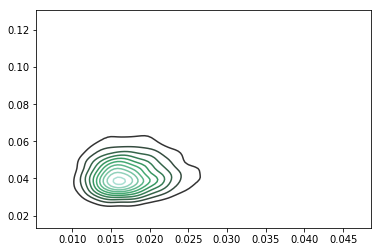

In [79]:
sns.kdeplot(ss[:,1], ss[:,0])
plt.show()

In [34]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [80]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [81]:
samples.shape

(3000, 20, 3, 4)

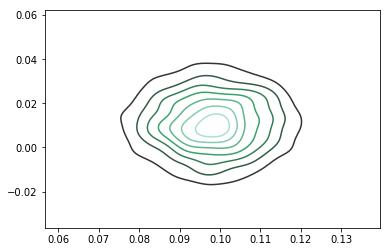

In [82]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [139]:
samples[:,10,2,0].mean()

0.09639029882481966

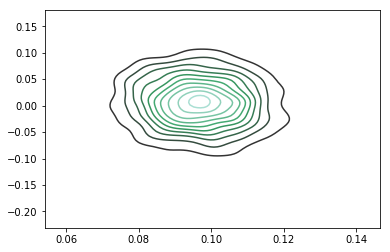

In [140]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [83]:
t = 10
# params[t]

In [84]:
np.mean(samples[:,t], axis=0)

array([[ 3.3247e-03, -7.3668e-03,  6.3002e-03,  1.1010e-02],
       [ 4.5848e-03, -3.7239e-04,  9.8147e-03,  3.6363e-03],
       [ 9.8738e-02, -1.8441e-03,  9.1986e-01,  1.1776e-04]])

In [85]:
np.std(samples[:,t], axis=0)

array([[0.0571, 0.032 , 0.0175, 0.0123],
       [0.0097, 0.0084, 0.0086, 0.0065],
       [0.0108, 0.0047, 0.024 , 0.003 ]])

In [163]:
np.mean(samples[:,t], axis=0)

array([[-0.2617, -0.0514, -0.1421, -1.1013],
       [ 0.0716,  0.1932,  0.6169,  0.2148],
       [ 0.2826, -0.0293,  0.8549,  0.9093]])

In [164]:
np.std(samples[:,t], axis=0)

array([[0.1349, 0.0932, 0.1238, 0.3107],
       [0.0814, 0.0982, 0.1407, 0.1506],
       [0.0623, 0.039 , 0.0645, 0.3178]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


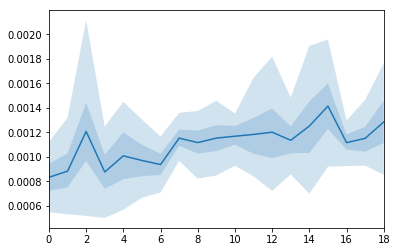

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


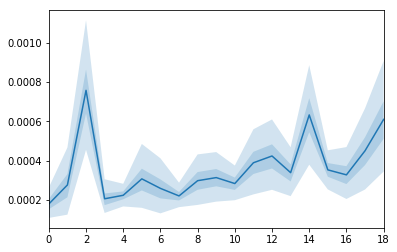

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


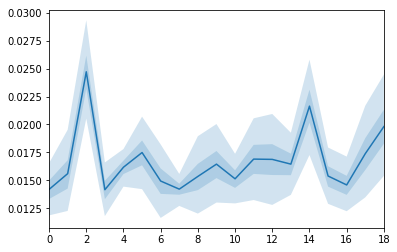

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()